In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import torch
print("GPU Available:", torch.cuda.is_available())
print("GPU Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

GPU Available: True
GPU Device Name: Tesla T4


In [36]:
!pip install transformers datasets evaluate rouge-score gradio
!pip install nltk

In [37]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate
import nltk
import numpy as np

# Download required NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
# Load the dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

# Let's start with T5-small model
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Reduce dataset size
train_size = 500  # Reduced from 1000
val_size = 50    # Reduced from 100

# Create smaller datasets
train_data = dataset["train"].select(range(train_size))
val_data = dataset["validation"].select(range(val_size))

print(f"Training examples: {len(train_data)}")
print(f"Validation examples: {len(val_data)}")

Training examples: 500
Validation examples: 50


In [39]:
def preprocess_function(examples):
    # T5 uses "summarize: " prefix for summarization tasks
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    # Setup the summaries
    labels = tokenizer(examples["highlights"], max_length=150, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Process our datasets
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_val = val_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [40]:
# Load ROUGE metric
rouge = evaluate.load('rouge')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    # Extract mid values
    result = {key: round(value * 100, 2) for key, value in result.items()}
    return result

In [41]:
# 1. First initialize the model
model_name = "t5-small"  # Make sure this matches what we used earlier
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")

# 2. Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    gradient_accumulation_steps=4
)

# 3. Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

# 4. Start training
trainer.train()

# 5. Save the model
model_save_path = "./summarization_model_local"
trainer.save_model(model_save_path)
print(f"Model saved to {model_save_path}")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss


Model saved to ./summarization_model_local


In [42]:
# Evaluation and testing function
def generate_summary(text, model, tokenizer, max_length=150):
    # Prepare the input
    inputs = tokenizer("summarize: " + text, max_length=512, truncation=True,
                      padding="max_length", return_tensors="pt").to("cuda")

    # Generate summary
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=max_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True,
        no_repeat_ngram_size=3
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Test function to compare models
def compare_models(test_text, model1, model2, tokenizer1, tokenizer2):
    summary1 = generate_summary(test_text, model1, tokenizer1)
    summary2 = generate_summary(test_text, model2, tokenizer2)

    print("Original Text:\n", test_text[:500], "...\n")
    print("Model 1 Summary:\n", summary1, "\n")
    print("Model 2 Summary:\n", summary2, "\n")

In [43]:
# Load the trained model from checkpoint
model_checkpoint = "./results/checkpoint-124"
trained_model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to("cuda")

In [44]:
# Test text - you can replace this with any text you want to summarize
test_text = """The development of artificial intelligence has revolutionized many industries,
from healthcare to transportation. Machine learning algorithms can now perform complex tasks
with high accuracy, while natural language processing has enabled better communication between
humans and machines. However, these advancements also raise important ethical considerations
about privacy, bias, and the future of work."""

# Generate summary using our trained model
summary = generate_summary(test_text, trained_model, tokenizer)
print("Original Text:\n", test_text)
print("\nGenerated Summary:\n", summary)

Original Text:
 The development of artificial intelligence has revolutionized many industries,
from healthcare to transportation. Machine learning algorithms can now perform complex tasks
with high accuracy, while natural language processing has enabled better communication between
humans and machines. However, these advancements also raise important ethical considerations
about privacy, bias, and the future of work.

Generated Summary:
 artificial intelligence has revolutionized many industries, from healthcare to transportation. machine learning algorithms can perform complex tasks with high accuracy. natural language processing has enabled better communication between humans and machines.


In [45]:
import gradio as gr

def summarize_text(input_text):
    return generate_summary(input_text, trained_model, tokenizer)

# Create the interface
demo = gr.Interface(
    fn=summarize_text,
    inputs=gr.Textbox(lines=10, label="Input Text"),
    outputs=gr.Textbox(label="Generated Summary"),
    title="Text Summarization Demo",
    description="Enter text to generate a summary using the fine-tuned T5 model.",
    examples=[
        ["Climate change continues to be one of the most pressing challenges facing our planet. Rising temperatures, extreme weather events, and melting ice caps are affecting ecosystems worldwide. Scientists warn that immediate action is needed to reduce greenhouse gas emissions and prevent catastrophic environmental damage."]
    ]
)

# Launch the interface
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8ca7971aa27b24edec.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [46]:
def generate_summary(text, model, tokenizer, max_length=150):
    # Prepare the input
    prefix = "summarize: " if "t5" in tokenizer.name_or_path else ""
    inputs = tokenizer(prefix + text, max_length=512, truncation=True,
                      padding="max_length", return_tensors="pt").to("cuda")

    if "bart" in tokenizer.name_or_path:
        summary_ids = model.generate(
            inputs["input_ids"],
            max_length=50,               # Even shorter maximum
            min_length=25,               # Higher minimum
            num_beams=6,                 # More beam search
            length_penalty=0.8,          # Encourage shorter sequences
            early_stopping=True,
            no_repeat_ngram_size=3,
            do_sample=True,
            top_p=0.7,                   # More focused sampling
            temperature=1.0,             # More randomness
            repetition_penalty=3.0,      # Even stronger repetition penalty
            forced_bos_token_id=0        # Force beginning of sequence
        )
    else:
        summary_ids = model.generate(
            inputs["input_ids"],
            max_length=100,
            min_length=30,
            num_beams=4,
            length_penalty=2.0,
            early_stopping=True,
            no_repeat_ngram_size=3
        )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [47]:
# Initialize BART model and tokenizer
bart_model_name = "facebook/bart-base"
bart_tokenizer = AutoTokenizer.from_pretrained(bart_model_name)
bart_model = AutoModelForSeq2SeqLM.from_pretrained(bart_model_name).to("cuda")

# Then we can use the preprocess_for_bart function
def preprocess_for_bart(examples):
    inputs = examples["article"]
    model_inputs = bart_tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = bart_tokenizer(examples["highlights"], max_length=150, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Process datasets for BART
bart_tokenized_train = train_data.map(preprocess_for_bart, batched=True)
bart_tokenized_val = val_data.map(preprocess_for_bart, batched=True)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [48]:
# Training arguments for BART
bart_training_args = TrainingArguments(
    output_dir="./bart_results",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./bart_logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="none",
    gradient_accumulation_steps=4
)

# Initialize BART trainer
bart_trainer = Trainer(
    model=bart_model,
    args=bart_training_args,
    train_dataset=bart_tokenized_train,
    eval_dataset=bart_tokenized_val,
    compute_metrics=compute_metrics,
)

# Train BART model
bart_trainer.train()

# Save BART model
bart_save_path = "./bart_model_local"
bart_trainer.save_model(bart_save_path)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [49]:
import gradio as gr
import pandas as pd
import evaluate

rouge = evaluate.load('rouge')

def compare_summaries(input_text):
    # Generate summaries from both models
    t5_summary = generate_summary(input_text, trained_model, tokenizer)
    bart_summary = generate_summary(input_text, bart_model, bart_tokenizer)

    # Calculate ROUGE scores
    t5_scores = rouge.compute(
        predictions=[t5_summary],
        references=[input_text],
        use_stemmer=True
    )

    bart_scores = rouge.compute(
        predictions=[bart_summary],
        references=[input_text],
        use_stemmer=True
    )

    # Calculate length statistics
    input_length = len(input_text.split())
    t5_length = len(t5_summary.split())
    bart_length = len(bart_summary.split())

    # Calculate compression ratios
    t5_compression = (1 - t5_length/input_length) * 100
    bart_compression = (1 - bart_length/input_length) * 100

    # Create combined statistics dataframe
    stats_df = pd.DataFrame({
        'Metric': ['Word Count', 'Compression Rate', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
        'Original': [input_length, '0%', '-', '-', '-'],
        'T5': [
            t5_length,
            f'{t5_compression:.1f}%',
            f"{t5_scores['rouge1']*100:.2f}%",
            f"{t5_scores['rouge2']*100:.2f}%",
            f"{t5_scores['rougeL']*100:.2f}%"
        ],
        'BART': [
            bart_length,
            f'{bart_compression:.1f}%',
            f"{bart_scores['rouge1']*100:.2f}%",
            f"{bart_scores['rouge2']*100:.2f}%",
            f"{bart_scores['rougeL']*100:.2f}%"
        ]
    })

    return t5_summary, bart_summary, stats_df

# Create the interface
demo = gr.Interface(
    fn=compare_summaries,
    inputs=gr.Textbox(lines=10, label="Input Text"),
    outputs=[
        gr.Textbox(label="T5 Model Summary"),
        gr.Textbox(label="BART Model Summary"),
        gr.Dataframe(label="Summary Statistics and ROUGE Scores")
    ],
    title="Text Summarization Model Comparison",
    description="Compare summaries generated by T5 and BART models with compression rates and ROUGE scores",
    examples=[
        ["The development of artificial intelligence has revolutionized many industries, from healthcare to transportation. Machine learning algorithms can now perform complex tasks with high accuracy, while natural language processing has enabled better communication between humans and machines. However, these advancements also raise important ethical considerations about privacy, bias, and the future of work."],
        ["Climate change continues to be one of the most pressing challenges facing our planet. Rising temperatures, extreme weather events, and melting ice caps are affecting ecosystems worldwide. Scientists warn that immediate action is needed to reduce greenhouse gas emissions and prevent catastrophic environmental damage."]
    ]
)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2672b445e7bbf7ceb0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [50]:
def collect_training_metrics(trainer, model_name):
    log_history = trainer.state.log_history

    # Get all unique keys from log_history
    all_keys = set()
    for entry in log_history:
        all_keys.update(entry.keys())

    history = {
        'model': [model_name] * len(log_history),
        'timestamps': [None] * len(log_history)
    }

    # Initialize all keys in history with empty lists to ensure consistent length
    for key in all_keys:
        history[key] = [None] * len(log_history)

    # Now populate values, handling potential missing values for some keys
    for i, entry in enumerate(log_history):
        for key, value in entry.items():
            history[key][i] = value

    return pd.DataFrame(history)

In [51]:
import pandas as pd

# Assuming collect_training_metrics is defined as in your previous cells
t5_metrics = collect_training_metrics(trainer, "T5") # Assuming 'trainer' is the T5 trainer
bart_metrics = collect_training_metrics(bart_trainer, "BART") # Assuming 'bart_trainer' is the BART trainer

all_metrics = pd.concat([t5_metrics, bart_metrics], ignore_index=True)

In [52]:
summary_stats = all_metrics.groupby('model')['loss'].describe()
print(summary_stats)

       count     mean       std     min       25%      50%       75%      max
model                                                                        
BART     2.0  7.29985  3.525281  4.8071  6.053475  7.29985  8.546225   9.7926
T5       2.0  8.22330  3.787688  5.5450  6.884150  8.22330  9.562450  10.9016


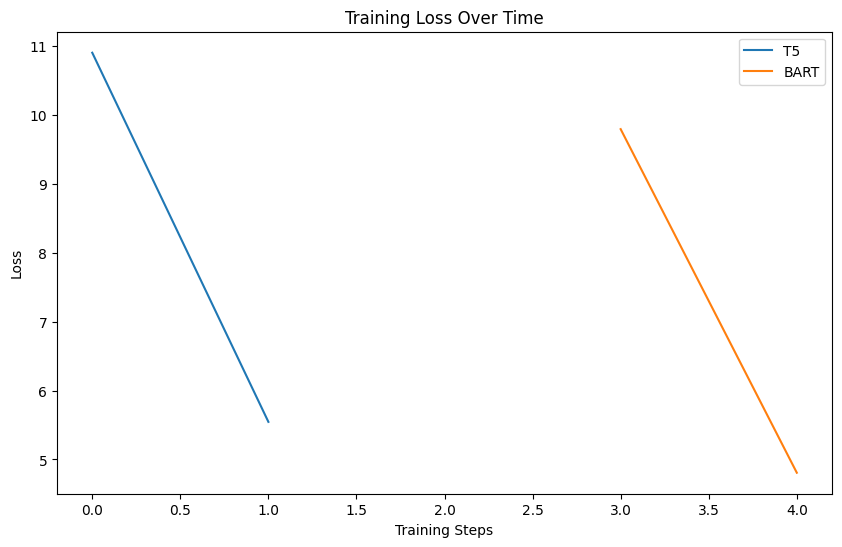

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for model in all_metrics['model'].unique():
    model_data = all_metrics[all_metrics['model'] == model]
    plt.plot(model_data.index, model_data['loss'], label=model)

plt.title('Training Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

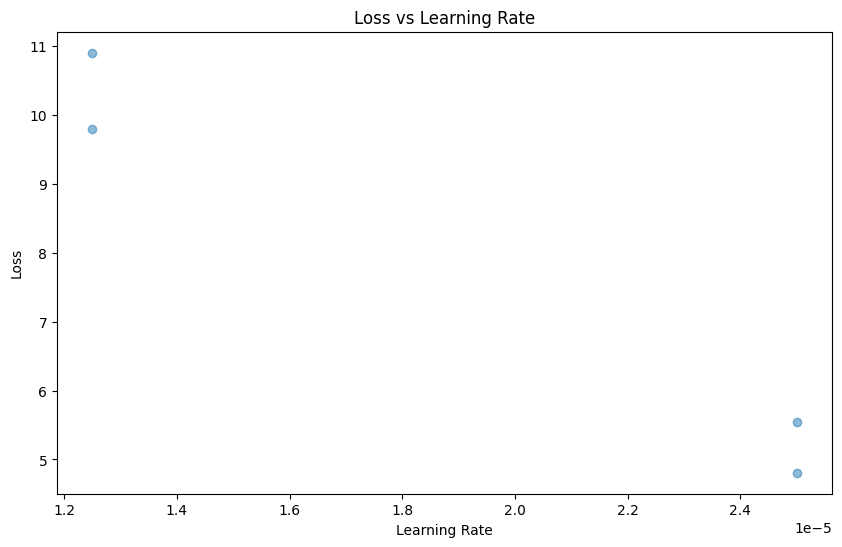

In [54]:
if 'learning_rate' in all_metrics.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(all_metrics['learning_rate'], all_metrics['loss'], alpha=0.5)
    plt.title('Loss vs Learning Rate')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.show()